# PubMed Abstract Crawler and Analyzer
Cited as Requested: 

Comeau DC, Wei CH, Islamaj Doğan R, and Lu Z. PMC text mining subset in BioC: about 3 million full text articles and growing, Bioinformatics, btz070, 2019

In [51]:
import requests
import pandas as pd
import numpy as np
import re
import time

## Web Crawling PubMed Searches and Extracting the Abstracts

In [52]:
BASE_URL = 'https://pubmed.ncbi.nlm.nih.gov'
SAMPLE_SEARCH_TERM = 'Smita S Patel'

url = BASE_URL + '/?term=' + SAMPLE_SEARCH_TERM.strip().replace(' ', '+') + '&sort=date' + '&size=100'
url

'https://pubmed.ncbi.nlm.nih.gov/?term=Smita+S+Patel&sort=date&size=100'

In [53]:
page = requests.get(url=url)
page

<Response [200]>

In [54]:
from bs4 import BeautifulSoup

In [55]:
soup = BeautifulSoup(page.content, 'html.parser')
documents = soup.findAll(class_= 'docsum-title')
print(documents[0])


<a class="docsum-title" data-article-id="36528058" data-full-article-url="from_term=Smita+S+Patel&amp;from_sort=date&amp;from_size=100&amp;from_pos=1" data-ga-action="1" data-ga-category="result_click" data-ga-label="36528058" href="/36528058/" ref="linksrc=docsum_link&amp;article_id=36528058&amp;ordinalpos=1&amp;page=1">
              
                The N-terminal domain of human mitochondrial helicase Twinkle has DNA-binding activity crucial for supporting processive DNA synthesis by polymerase γ.
              
            </a>


In [56]:
documents[0].contents[0].strip()

'The N-terminal domain of human mitochondrial helicase Twinkle has DNA-binding activity crucial for supporting processive DNA synthesis by polymerase γ.'

In [57]:
BASE_URL + documents[0].get('href')

'https://pubmed.ncbi.nlm.nih.gov/36528058/'

In [58]:
documents[0].get('data-article-id')

'36528058'

### Creating a Loop for a Single Page

In [59]:
df = pd.DataFrame(columns= ['ArticleID', 'ArticleName', 'URL'])
for document in documents:
    article_id = document.get('data-article-id')
    article_name = document.contents[0].strip()
    article_url = BASE_URL + document.get('href')

    df.loc[len(df.index)] = [article_id, article_name, article_url]
df.head()

,ArticleID,ArticleName,URL
0,36528058,The N-terminal domain of human mitochondrial h...,https://pubmed.ncbi.nlm.nih.gov/36528058/
1,36227977,Real-time dynamic single-molecule protein sequ...,https://pubmed.ncbi.nlm.nih.gov/36227977/
2,35934486,"Quantitative methods to study helicase, DNA po...",https://pubmed.ncbi.nlm.nih.gov/35934486/
3,35437807,The intrinsically disordered CARDs-Helicase li...,https://pubmed.ncbi.nlm.nih.gov/35437807/
4,33870232,Assembly and Cryo-EM structure determination o...,https://pubmed.ncbi.nlm.nih.gov/33870232/


In [60]:
article_page = requests.get(url= df.loc[0]['URL'])
article_page

<Response [200]>

In [61]:
article_soup = BeautifulSoup(article_page.content, 'html.parser')

authors_list_items = article_soup.findAll(class_='authors-list-item')
authors_list_items[0]

<span class="authors-list-item"><a class="full-name" data-ga-action="author_link" data-ga-category="search" data-ga-label="Laura C Johnson" href="/?term=Johnson+LC&amp;cauthor_id=36528058" ref="linksrc=author_name_link">Laura C Johnson</a><sup class="affiliation-links"><span class="author-sup-separator"> </span><a class="affiliation-link" href="#affiliation-1" ref="linksrc=author_aff" title="Department of Biochemistry and Molecular Biology, Robert Wood Johnson Medical School, Rutgers University, Piscataway, New Jersey, USA; Graduate School of Biomedical Sciences, Robert Wood Johnson Medical School, Rutgers University, Piscataway, New Jersey, USA.">
                1
              </a></sup><span class="comma">, </span></span>

In [62]:
authors_list_items[0].find(class_='full-name').contents[0]

'Laura C Johnson'

In [63]:
authors_list_items[0].find(class_='affiliation-link').get('title')

'Department of Biochemistry and Molecular Biology, Robert Wood Johnson Medical School, Rutgers University, Piscataway, New Jersey, USA; Graduate School of Biomedical Sciences, Robert Wood Johnson Medical School, Rutgers University, Piscataway, New Jersey, USA.'

In [64]:
article_soup.find('div', {'id': 'eng-abstract'}).find('p').text.strip()

'Twinkle is the ring-shaped replicative helicase within the human mitochondria with high homology to bacteriophage T7 gp4 helicase-primase. Unlike many orthologs of Twinkle, the N-terminal domain (NTD) of human Twinkle has lost its primase activity through evolutionarily acquired mutations. The NTD has no demonstrated activity thus far; its role has remained unclear. Here, we biochemically characterize the isolated NTD and C-terminal domain (CTD) with linker to decipher their contributions to full-length Twinkle activities. This novel CTD construct hydrolyzes ATP, has weak DNA unwinding activity, and assists DNA polymerase γ (Polγ)-catalyzed strand-displacement synthesis on short replication forks. However, CTD fails to promote multikilobase length product formation by Polγ in rolling-circle DNA synthesis. Thus, CTD retains all the motor functions but struggles to implement them for processive translocation. We show that NTD has DNA-binding activity, and its presence stabilizes Twinkle

Note: This needs to be made smarter...right now anyuthiung wil raise it a general exception

In [65]:
articles = pd.DataFrame(columns= ['ArticleID','Abstract'])
for i, entry in df.iterrows():
    try:
        response = requests.get(entry['URL'])
        if response.status_code == 200:
            article_soup = BeautifulSoup(response.content, 'html.parser')
            authors_list_items = article_soup.findAll(class_='authors-list-item')
            author_names = [name.find(class_='full-name').contents[0] for name in authors_list_items]
            if SAMPLE_SEARCH_TERM not in author_names: continue
            abstract = article_soup.find('div', {'id': 'eng-abstract'}).find('p').text.strip()
            articles.loc[len(articles.index)] = [entry['ArticleID'], abstract]
            time.sleep(5)
        else:
            print(f"The article {entry['ArticleName']} could not be found at the URL: {entry['URL']}")
    except Exception as e:
        print(f"Exception raised for the article {entry['ArticleName']} at the URL: {entry['URL']}")

Exception raised for the article Structural biology: Steps in the right direction. at the URL: https://pubmed.ncbi.nlm.nih.gov/19956250/
Exception raised for the article Mechanisms of helicases. at the URL: https://pubmed.ncbi.nlm.nih.gov/16670085/
Exception raised for the article Fluorescence methods for studying the kinetics and thermodynamics of transcription initiation. at the URL: https://pubmed.ncbi.nlm.nih.gov/14712683/


In [66]:
articles.head()

,ArticleID,Abstract
0,36528058,Twinkle is the ring-shaped replicative helicas...
1,36227977,Studies of the proteome would benefit greatly ...
2,35934486,Genome replication is accomplished by highly r...
3,35437807,The innate immune receptor RIG-I provides a fi...
4,33870232,"In yeast mitochondria, transcription initiatio..."


In [67]:
abstracts = pd.merge(df, articles, on='ArticleID')

In [68]:
abstracts.head()

,ArticleID,ArticleName,URL,Abstract
0,36528058,The N-terminal domain of human mitochondrial h...,https://pubmed.ncbi.nlm.nih.gov/36528058/,Twinkle is the ring-shaped replicative helicas...
1,36227977,Real-time dynamic single-molecule protein sequ...,https://pubmed.ncbi.nlm.nih.gov/36227977/,Studies of the proteome would benefit greatly ...
2,35934486,"Quantitative methods to study helicase, DNA po...",https://pubmed.ncbi.nlm.nih.gov/35934486/,Genome replication is accomplished by highly r...
3,35437807,The intrinsically disordered CARDs-Helicase li...,https://pubmed.ncbi.nlm.nih.gov/35437807/,The innate immune receptor RIG-I provides a fi...
4,33870232,Assembly and Cryo-EM structure determination o...,https://pubmed.ncbi.nlm.nih.gov/33870232/,"In yeast mitochondria, transcription initiatio..."


## Doing Some Analysis

In [69]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('english')

In [70]:
tokenized_abstract = word_tokenize(abstracts.loc[0]['Abstract'])
tokenized_abstract = [w for w in tokenized_abstract if not w.lower() in stop_words]
tokenized_abstract = [w for w in tokenized_abstract if not w.lower() in [',','.','?','!','"', "'", '(', ')']]
tokenized_abstract

['Twinkle',
 'ring-shaped',
 'replicative',
 'helicase',
 'within',
 'human',
 'mitochondria',
 'high',
 'homology',
 'bacteriophage',
 'T7',
 'gp4',
 'helicase-primase',
 'Unlike',
 'many',
 'orthologs',
 'Twinkle',
 'N-terminal',
 'domain',
 'NTD',
 'human',
 'Twinkle',
 'lost',
 'primase',
 'activity',
 'evolutionarily',
 'acquired',
 'mutations',
 'NTD',
 'demonstrated',
 'activity',
 'thus',
 'far',
 ';',
 'role',
 'remained',
 'unclear',
 'biochemically',
 'characterize',
 'isolated',
 'NTD',
 'C-terminal',
 'domain',
 'CTD',
 'linker',
 'decipher',
 'contributions',
 'full-length',
 'Twinkle',
 'activities',
 'novel',
 'CTD',
 'construct',
 'hydrolyzes',
 'ATP',
 'weak',
 'DNA',
 'unwinding',
 'activity',
 'assists',
 'DNA',
 'polymerase',
 'γ',
 'Polγ',
 '-catalyzed',
 'strand-displacement',
 'synthesis',
 'short',
 'replication',
 'forks',
 'However',
 'CTD',
 'fails',
 'promote',
 'multikilobase',
 'length',
 'product',
 'formation',
 'Polγ',
 'rolling-circle',
 'DNA',
 'synt

Note: More NLTK work will need to be done to extract the thruly meaningful words and phrases from the text...this is a very basic version for testing

In [71]:
abstract_keywords = pd.DataFrame(columns= ['ArticleID', 'Keywords'])
for i, entry in abstracts.iterrows():
    tokenized_abstract = word_tokenize(entry['Abstract'])
    tokenized_abstract = [w for w in tokenized_abstract if not w.lower() in stop_words]
    tokenized_abstract = [w for w in tokenized_abstract if not w.lower() in [',','.','?','!','"', "'", '(', ')']]
    abstract_keywords.loc[len(abstract_keywords.index)] = [entry['ArticleID'], tokenized_abstract]

abstract_keywords.head()

,ArticleID,Keywords
0,36528058,"[Twinkle, ring-shaped, replicative, helicase, ..."
1,36227977,"[Studies, proteome, would, benefit, greatly, m..."
2,35934486,"[Genome, replication, accomplished, highly, re..."
3,35437807,"[innate, immune, receptor, RIG-I, provides, fi..."
4,33870232,"[yeast, mitochondria, transcription, initiatio..."


In [72]:
abstracts = pd.merge(abstracts, abstract_keywords, on='ArticleID')
abstracts.head()

,ArticleID,ArticleName,URL,Abstract,Keywords
0,36528058,The N-terminal domain of human mitochondrial h...,https://pubmed.ncbi.nlm.nih.gov/36528058/,Twinkle is the ring-shaped replicative helicas...,"[Twinkle, ring-shaped, replicative, helicase, ..."
1,36227977,Real-time dynamic single-molecule protein sequ...,https://pubmed.ncbi.nlm.nih.gov/36227977/,Studies of the proteome would benefit greatly ...,"[Studies, proteome, would, benefit, greatly, m..."
2,35934486,"Quantitative methods to study helicase, DNA po...",https://pubmed.ncbi.nlm.nih.gov/35934486/,Genome replication is accomplished by highly r...,"[Genome, replication, accomplished, highly, re..."
3,35437807,The intrinsically disordered CARDs-Helicase li...,https://pubmed.ncbi.nlm.nih.gov/35437807/,The innate immune receptor RIG-I provides a fi...,"[innate, immune, receptor, RIG-I, provides, fi..."
4,33870232,Assembly and Cryo-EM structure determination o...,https://pubmed.ncbi.nlm.nih.gov/33870232/,"In yeast mitochondria, transcription initiatio...","[yeast, mitochondria, transcription, initiatio..."


In [73]:
# Let's Put this in a CSV for just-in-case storage
abstracts.to_csv('abstracts.csv')

In [74]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Basic (with very little NLTK processing) Word Cloud for 1st Page Abstract Results

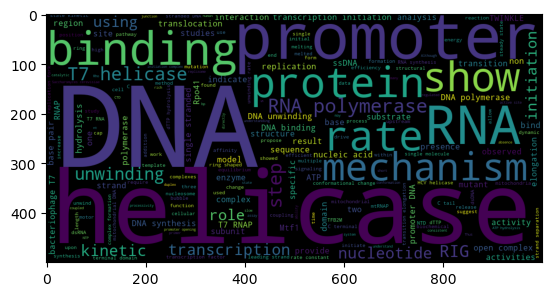

In [75]:
all_keywords = []
for i, entry in abstracts.iterrows():
    all_keywords += entry['Keywords'] 

keyword_string = (' ').join(all_keywords)
wordcloud = WordCloud(width = 1000, height = 500).generate(keyword_string)
plt.imshow(wordcloud)